# Internal control experiments

This notebooks runs some experiments with internal bandit NRM control. 

For the application of the NRM model to resource management to one
computational job, the global resource optimization problem is the following:

$$
\begin{array}{l}
    \min \quad e_{\text{total}} \\
	\text{s.t.} \quad  t > \tau t_{\text{ref}}
\end{array}
$$

Where $e_{\text{total}}$ denotes the total energy spent by the system during
the lifetime of the job, whose duration is denoted by $t^T$. We denote by
$t_{\text{ref}}$ a reference measurement of the runtime of the job on an
unmanaged system. $\tau <1$ is a parameter controlling the amount of runtime
degradation allowed for the job.

The value of this global objective can be easily measured a-posteriori for a
computational job using power instrumentation techniques. Assuming both
workload and platform behavior to be deterministic, this objective is measured
using two runs of the system: A first run without resource management to
acquire $t_{\text{ref}}$, and one run with NRM enabled. In order for NRM's
round-based control strategy to address this problem, we need an online loss
value however. This loss is obtained using the following loose assumptions:

- The passive power consumption of the node is fixed and known. [1]

- The total power consumption in a given time period can be estimated as
  the sum of the static node consumption over that period and the RAPL power
  measurement over that period. [2]

- The impact of a choice of power-cap on the job's runtime can be
  interpolated linearly from its impact on CPU counters. [3]


Denoting as in the previous section the round counter by $0<r<T$, the known
passive static power consumption by $p_{\text{static}}$, the starting time of
the job by $t^0$ and the end time of round $r$ by $t^r$, we can write the total
energy expenditure of the job based on RAPL power measurements $p^r$ using
assumptions 1 and 2 as:

$$
	e_{\text{total}} = \sum_{r=1}^{r=T} (p^r + p_{\text{static}}) (t^{r-1} - t^{r})
$$

Using assumption 3 means that we can reasonably estimate the
change in job runtime incurred by the choice of power-cap in round $r$ by
evaluating $\frac{s^r_{\text{ref}}}{s^r}$. We use this as part of our proxy
cost in two ways. First, this quantity is used to evaluate breaching of the
constraint on $t$, and second, it is used to adjust for an expected increase in
the number of rounds due to the impact on job runtime. This gives rise to the
following value for the loss at round $r$:

$$
	\ell^r = \mathbb{\huge 1}_{\left( \frac{s^r}{s^r_{\text{ref}}}>\tau \right)}
   \left( \frac{s^r_{\text{ref}}}{s^r} \left( p^r + p_{\text{static}} \right) \right)
$$


In [1]:
cd ..

/home/fre/workspace/hnrm


In [2]:
%%capture
%%bash
./shake.sh build # for the daemon 
./shake.sh client # for the upstream client
./shake.sh pyclient # for the shared client library

In [2]:
%load_ext nb_black
import json

daemonCfgs = {
    "controlOn": {
        "controlCfg": {
            "staticPower": {"fromuW": 200000000},
            "referenceMeasurementRoundInterval": 10,
            "learnCfg": {"lagrangeConstraint": 1},
            "speedThreshold": 0.9,
            "minimumControlInterval": {"fromuS": 1000000},
        },
        "verbose": "Debug",
    },
    "pcapMax": {},
}


def perfwrapped(cmd, args):
    return [
        {
            "cmd": cmd,
            "args": args,
            "sliceID": "toto",
            "manifest": {
                "app": {
                    "slice": {"cpus": 1, "mems": 1},
                    "perfwrapper": {
                        "perfLimit": {"fromOps": 100000},
                        "perfFreq": {"fromHz": 1},
                    },
                },
                "name": "perfwrap",
            },
        }
    ]


stream = perfwrapped("stream_c", [])
lammps = perfwrapped(
    "mpiexec",
    ["-n", "24", "amg", "-problem", "2", "-n", "90", "90", "90", "-P", "2", "12", "1"],
)

<IPython.core.display.Javascript object>

In [3]:
import nrm.tooling as nrm

host = nrm.Local()

<IPython.core.display.Javascript object>

In [5]:
host.start_daemon(daemonCfgs["pcapMax"])
assert host.check_daemon()
print(host.get_cpd())

connecting
connected to tcp://localhost:2345
Problem 
    { sensors = Map 
        [ 
            ( SensorID { sensorID = "RaplKey (PackageID 0)" }
            , Sensor 
                { range = 0.0 ... 300.0
                , maxFrequency = 3.0
                } 
            ) 
        ]
    , actuators = Map 
        [ 
            ( ActuatorID { actuatorID = "RaplKey (PackageID 0)" }
            , Actuator 
                { actions = 
                    [ DiscreteDouble 100.0
                    , DiscreteDouble 200.0
                    ] 
                }
            ) 
        ]
    , objectives = []
    , constraints = []
    } 


<IPython.core.display.Javascript object>

The next cell just stops the daemon cleanly.

In [6]:
host.stop_daemon()
assert host.check_daemon() == False

<IPython.core.display.Javascript object>

### Helpers

For performing experiments:

In [26]:
import time
from collections import defaultdict


def do_workload(host, daemonCfg, workload):
    host.start_daemon(daemonCfg)
    print("Starting the workload")
    host.run_workload(workload)
    history = defaultdict(list)
    # print(host.get_state())
    getCPD = True
    try:
        while host.check_daemon() and not host.workload_finished():
            measurement_message = host.workload_recv()
            msg = json.loads(measurement_message)
            if "pubMeasurements" in msg:
                if getCPD:
                    getCPD = False
                    time.sleep(3)
                    cpd = host.get_cpd()
                    print(cpd)
                    cpd = dict(cpd)
                    print("Sensor identifier list:")
                    for sensorID in [sensor[0] for sensor in cpd["sensors"]]:
                        print("- %s" % sensorID)
                    print("Actuator identifier list:")
                    for sensorID in [sensor[0] for sensor in cpd["actuators"]]:
                        print("- %s" % sensorID)
                content = msg["pubMeasurements"][1][0]
                t = content["time"]
                sensorID = content["sensorID"]
                x = content["sensorValue"]
                print(
                    ".",
                    end=""
                    # "Measurement: originating at time %s for sensor %s of value %s"
                    #% (content["time"], content["sensorID"], content["sensorValue"])
                )
                history["sensor-" + sensorID].append((t, x))
            if "pubCPD" in msg:
                print("R")
            if "pubAction" in msg:
                # print(host.get_state())
                print(msg)
                t, contents, meta, controller = msg["pubAction"]
                if "bandit" in controller.keys():
                    for key in meta.keys():
                        history["actionType"].append((t, key))
                    if "referenceMeasurementDecision" in meta.keys():
                        print("a:reference")
                    elif "initialDecision" in meta.keys():
                        print("a:initial decision")
                    elif "innerDecision" in meta.keys():
                        print("a:inner")
                        counter = 0
                        for value in meta["innerDecision"]["constraints"]:
                            history["constraint-" + str(counter)].append(
                                (t, value["fromConstraintValue"])
                            )
                            counter = counter + 1
                        counter = 0
                        for value in meta["innerDecision"]["objectives"]:
                            history["objective-" + str(counter)].append(
                                (t, value["fromObjectiveValue"])
                            )
                            counter = counter + 1
                        history["loss"].append((t, meta["innerDecision"]["loss"]))
                for content in contents:
                    actuatorID = content["actuatorID"] + "(action)"
                    x = content["actuatorValue"]
                    history[actuatorID].append((t, x))
                    for arm in controller["bandit"]["lagrange"]["lagrangeConstraint"][
                        "weights"
                    ]:
                        value = arm["action"][0]["actuatorValue"]
                        history[str(value / 1000000) + "-probability"].append(
                            (t, arm["probability"]["getProbability"])
                        )
                        history[str(value / 1000000) + "-cumulativeLoss"].append(
                            (t, arm["cumulativeLoss"]["getCumulativeLoss"])
                        )
                # print(
                # "Action: originating at time %s for actuator %s of value %s"
                #% (t,actuatorID,x)
                # )
            host.check_daemon()
    except:
        return history
    host.stop_daemon()
    return history

<IPython.core.display.Javascript object>

For plotting:

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_history(history, nplots):
    fig = plt.figure()
    fig, (axes) = plt.subplots(nplots, 1, sharex=True)
    fig.subplots_adjust(wspace=0.1)
    fig.set_size_inches(17, 25 * nplots / 10, forward=True)

    minTime = min(
        [
            min([pd.Timestamp(m[0], unit="us") for m in measurements])
            for cname, measurements in history.items()
        ]
    )
    maxTime = max(
        [
            max([pd.Timestamp(m[0], unit="us") for m in measurements])
            for cname, measurements in history.items()
        ]
    )

    plt.xlim(minTime, maxTime)

    for ((columnName, measurements), ax) in zip(history.items(), axes):
        ax.set_title(columnName)
        dataframe = pd.DataFrame(
            data=[(pd.Timestamp(t, unit="us"), m) for t, m in measurements]
        )
        dataframe.columns = ["time", "value"]
        if dataframe.dtypes["value"] == "object":
            sns.catplot(ax=ax, x="time", y="value", kind="swarm", data=dataframe)
        else:
            sns.scatterplot(ax=ax, x="time", y="value", data=dataframe)
    return (minTime, maxTime)

<IPython.core.display.Javascript object>

In [6]:
history_pcapMax = do_workload(host, daemonCfgs["pcapMax"], stream)

connecting
connected to tcp://localhost:2345
Starting the workload
Problem 
    { sensors = Map 
        [ 
            ( SensorID { sensorID = "RaplKey (PackageID 0)" }
            , Sensor 
                { range = 0.0 ... 300.0
                , maxFrequency = 3.0
                } 
            ) 
        ]
    , actuators = Map 
        [ 
            ( ActuatorID { actuatorID = "RaplKey (PackageID 0)" }
            , Actuator 
                { actions = 
                    [ DiscreteDouble 100.0
                    , DiscreteDouble 200.0
                    ] 
                }
            ) 
        ]
    , objectives = []
    , constraints = []
    } 
Sensor identifier list:
- RaplKey (PackageID 0)
Actuator identifier list:
- RaplKey (PackageID 0)
........................................................................................................................................................................................................................................

<IPython.core.display.Javascript object>

Runtime: 0 days 00:06:21.658894


/nix/store/ws7algif7c1inwk7s6hvmml5rhsfca4w-python3.7-pandas-0.24.2/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

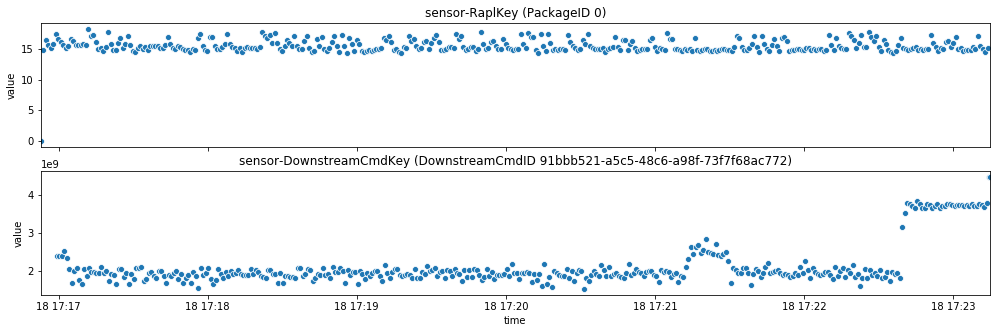

<IPython.core.display.Javascript object>

In [7]:
t_min_pMax, t_max_pMax = plot_history(history_pcapMax, 2)
runtime = t_max_pMax - t_min_pMax
print("Runtime: %s" % runtime)

In [23]:
history_controlOn = do_workload(host, daemonCfgs["controlOn"], stream)

connecting
connected to tcp://localhost:2345
Starting the workload
Problem 
    { sensors = Map 
        [ 
            ( SensorID { sensorID = "RaplKey (PackageID 0)" }
            , Sensor 
                { range = 0.0 ... 300.0
                , maxFrequency = 3.0
                } 
            ) 
        ]
    , actuators = Map 
        [ 
            ( ActuatorID { actuatorID = "RaplKey (PackageID 0)" }
            , Actuator 
                { actions = 
                    [ DiscreteDouble 100.0
                    , DiscreteDouble 200.0
                    ] 
                }
            ) 
        ]
    , objectives = 
        [ 
            ( 1.0
            , OAdd 
                ( OValue 
                    ( SensorID { sensorID = "RaplKey (PackageID 0)" } )
                ) ( OScalar 200.0 )
            ) 
        ]
    , constraints = []
    } 
Sensor identifier list:
- RaplKey (PackageID 0)
Actuator identifier list:
- RaplKey (PackageID 0)
.....R
{'pubAction': [1582

..{'pubAction': [1582058804414435.8, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4315112383834745}], 'constraints': [{'fromConstraintValue': 0.9201555307283512}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 5, 'weights': [{'probability': {'getProbability': 0.7166986884835084}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 2.3821505928085074}}, {'probability': {'getProbability': 0.28330131151649157}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 4.61178085217985}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [2527565351.0000553]], ['RaplKey (PackageID 0)', [15.917580023259706]]], 'referenceMeasurementCo

..{'pubAction': [1582058810415445.2, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4321434910428954}], 'constraints': [{'fromConstraintValue': 0.9130070113072047}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 11, 'weights': [{'probability': {'getProbability': 0.36523847282731164}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 8.315689560009979}}, {'probability': {'getProbability': 0.6347615271726883}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 6.216383004407417}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [2527565351.0000553]], ['RaplKey (PackageID 0)', [15.917580023259706]]], 'referenceMeasurementC

..{'pubAction': [1582058816414767, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.43143432047834335}], 'constraints': [{'fromConstraintValue': 0.9667032644223206}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 16, 'weights': [{'probability': {'getProbability': 0.1338559236650456}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 17.22242601059576}}, {'probability': {'getProbability': 0.8661440763349544}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 8.535941923182019}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [2636706702.000028, 2527565351.0000553]], ['RaplKey (PackageID 0)', [16.194030068705253, 15.91758

..{'pubAction': [1582058822414598.5, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'referenceMeasurementDecision': {}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 21, 'weights': [{'probability': {'getProbability': 0.0646617237669897}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 24.693145068964448}}, {'probability': {'getProbability': 0.9353382762330102}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 10.3416789851457}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [2636706702.000028, 2527565351.0000553]], ['RaplKey (PackageID 0)', [16.194030068705253, 15.917580023259706]]], 'referenceMeasurementCounter': 0, 'bufferedMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a395

..{'pubAction': [1582058828414612, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4321653713819886}], 'constraints': [{'fromConstraintValue': 0.9132736431542268}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 27, 'weights': [{'probability': {'getProbability': 0.20762005810919215}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 24.693145068964448}}, {'probability': {'getProbability': 0.7923799418908078}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 16.490348501981142}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [2495161263.0000005, 2636706702.000028, 2527565351.0000553]], ['RaplKey (PackageID 0)', [15.244

..{'pubAction': [1582058834414800.8, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4320679831199411}], 'constraints': [{'fromConstraintValue': 0.9549037169049617}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 32, 'weights': [{'probability': {'getProbability': 0.28679257989455453}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 26.301725278111135}}, {'probability': {'getProbability': 0.7132074201054456}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 20.20926486084606}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3527057241.000062, 2495161263.0000005, 2636706702.000028, 2527565351.0000553]], ['RaplKey (Pa

..{'pubAction': [1582058840414482, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.43191899314121135}], 'constraints': [{'fromConstraintValue': 1.5473935533042036}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 6, 'weights': [{'probability': {'getProbability': 0.7738025955583645}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 2.8096017361269894}}, {'probability': {'getProbability': 0.22619740444163552}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 6.112879910762769}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3527057241.000062, 2495161263.0000005, 2636706702.000028, 2527565351.0000553]], ['RaplKey (Pack

..{'pubAction': [1582058846415079.2, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.43055428709595045}], 'constraints': [{'fromConstraintValue': 1.3532430521132555}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 11, 'weights': [{'probability': {'getProbability': 0.9079555910746722}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 6.21014138577639}}, {'probability': {'getProbability': 0.09204440892532786}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 14.904122646504534}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [4388257824.00005, 3527057241.000062, 2495161263.0000005, 2636706702.000028, 2527565351.000055

..{'pubAction': [1582058851415867.2, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4321430974257319}], 'constraints': [{'fromConstraintValue': 1.0878681504523988}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 16, 'weights': [{'probability': {'getProbability': 0.6319981845078129}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 12.388366758648521}}, {'probability': {'getProbability': 0.36800181549218713}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 14.904122646504534}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [4388257824.00005, 3527057241.000062, 2495161263.0000005, 2636706702.000028, 2527565351.00005

..{'pubAction': [1582058856415620, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'referenceMeasurementDecision': {}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 20, 'weights': [{'probability': {'getProbability': 0.7533019491005416}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 14.973446662946747}}, {'probability': {'getProbability': 0.24669805089945845}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 20.817920129387073}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [4388257824.00005, 3527057241.000062, 2495161263.0000005, 2636706702.000028, 2527565351.0000553]], ['RaplKey (PackageID 0)', [15.277143547975793, 16.771007414801183, 15.24412947560423, 16.194030068705253, 15.91758

..{'pubAction': [1582058861420165.2, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4350408872551868}], 'constraints': [{'fromConstraintValue': 1.0144701583826052}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 25, 'weights': [{'probability': {'getProbability': 0.6256960045584664}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 20.5463217326034}}, {'probability': {'getProbability': 0.37430399544153364}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 23.569640245961104}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3591024354.0000815, 4388257824.00005, 3527057241.000062, 2495161263.0000005, 2636706702.000028

..{'pubAction': [1582058866421421, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.431499581070921}], 'constraints': [{'fromConstraintValue': 1.1090983229276197}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 30, 'weights': [{'probability': {'getProbability': 0.6276910033163834}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 25.06588494203093}}, {'probability': {'getProbability': 0.3723089966836165}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 28.44440217951927}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3591024354.0000815, 4388257824.00005, 3527057241.000062, 2495161263.0000005, 2636706702.000028, 25

..{'pubAction': [1582058871416640.8, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.432290626162963}], 'constraints': [{'fromConstraintValue': 0.9844606628603377}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 34, 'weights': [{'probability': {'getProbability': 0.8254508751073475}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 26.65902550755845}}, {'probability': {'getProbability': 0.1745491248926526}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 37.37959812474115}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3432482573.0002027, 3591024354.0000815, 4388257824.00005, 3527057241.000062, 2495161263.0000005,

..{'pubAction': [1582058876421727.8, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.43187973547904407}], 'constraints': [{'fromConstraintValue': 1.0312136219095778}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 39, 'weights': [{'probability': {'getProbability': 0.7788587849524117}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 31.67654974123626}}, {'probability': {'getProbability': 0.22114121504758835}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 40.99866676429496}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3432482573.0002027, 3591024354.0000815, 4388257824.00005, 3527057241.000062, 2495161263.00000

..{'pubAction': [1582058881421858, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4311693668419821}], 'constraints': [{'fromConstraintValue': 1.140057313880193}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 43, 'weights': [{'probability': {'getProbability': 0.7722285752736857}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 35.41477654057046}}, {'probability': {'getProbability': 0.22777142472631437}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 44.918756681783705}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3662229490.000038, 3432482573.0002027, 3591024354.0000815, 4388257824.00005, 3527057241.000062, 

..{'pubAction': [1582058886432106.5, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.43105358620779577}], 'constraints': [{'fromConstraintValue': 1.1206760683352368}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 48, 'weights': [{'probability': {'getProbability': 0.892945021544987}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 38.67844894814966}}, {'probability': {'getProbability': 0.10705497845501295}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 56.14528454352884}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3662229490.000038, 3432482573.0002027, 3591024354.0000815, 4388257824.00005, 3527057241.000062

..{'pubAction': [1582058891435285, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4335014567316069}], 'constraints': [{'fromConstraintValue': 1.1233821395278105}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 52, 'weights': [{'probability': {'getProbability': 0.8173106820614595}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 43.29385281790919}}, {'probability': {'getProbability': 0.18268931793854043}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 56.14528454352884}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3745333355.0000377, 3662229490.000038, 3432482573.0002027, 3591024354.0000815, 4388257824.00005,

..{'pubAction': [1582058896439198.2, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4313927882045721}], 'constraints': [{'fromConstraintValue': 1.1253984201934966}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 57, 'weights': [{'probability': {'getProbability': 0.9217099867683364}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 46.627833904147444}}, {'probability': {'getProbability': 0.07829001323166367}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 68.79146913739241}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3745333355.0000377, 3662229490.000038, 3432482573.0002027, 3591024354.0000815, 4388257824.000

..{'pubAction': [1582058901457199.2, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.431270651687308}], 'constraints': [{'fromConstraintValue': 1.075751517094794}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 61, 'weights': [{'probability': {'getProbability': 0.8706392193129612}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 51.052532120601875}}, {'probability': {'getProbability': 0.1293607806870388}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 68.79146913739241}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3685064522.0000243, 3745333355.0000377, 3662229490.000038, 3432482573.0002027, 3591024354.000081

..{'pubAction': [1582058906464524.8, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4334717218466026}], 'constraints': [{'fromConstraintValue': 1.0731726134702504}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 66, 'weights': [{'probability': {'getProbability': 0.880081755824711}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 55.59568353586456}}, {'probability': {'getProbability': 0.119918244175289}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 74.89739537343769}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3685064522.0000243, 3745333355.0000377, 3662229490.000038, 3432482573.0002027, 3591024354.0000815

..{'pubAction': [1582058911463482, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'referenceMeasurementDecision': {}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 70, 'weights': [{'probability': {'getProbability': 0.9128931606037604}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 58.890000510035556}}, {'probability': {'getProbability': 0.08710683939623964}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 82.33143609177496}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3685064522.0000243, 3745333355.0000377, 3662229490.000038, 3432482573.0002027, 3591024354.0000815, 4388257824.00005, 3527057241.000062, 2495161263.0000005, 2636706702.000028]], ['RaplKey (PackageID 0)', [15.635325

..{'pubAction': [1582058916458949, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4348624954782595}], 'constraints': [{'fromConstraintValue': 0.982456900297636}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 75, 'weights': [{'probability': {'getProbability': 0.848714051315339}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 64.5126109892764}}, {'probability': {'getProbability': 0.15128594868466103}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 82.33143609177496}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3532537564.000007, 3685064522.0000243, 3745333355.0000377, 3662229490.000038, 3432482573.0002027, 3

..{'pubAction': [1582058921464085.2, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4306135615042461}], 'constraints': [{'fromConstraintValue': 1.043867794017491}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 80, 'weights': [{'probability': {'getProbability': 0.7487054985454729}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 70.6764397619658}}, {'probability': {'getProbability': 0.25129450145452714}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 82.33143609177496}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3532537564.000007, 3685064522.0000243, 3745333355.0000377, 3662229490.000038, 3432482573.0002027

..{'pubAction': [1582058926461914.8, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4311937646201122}], 'constraints': [{'fromConstraintValue': 0.996745247126782}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 84, 'weights': [{'probability': {'getProbability': 0.7302424712852511}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 74.71982422862547}}, {'probability': {'getProbability': 0.2697575287147489}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 85.61719187509561}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3735463211.0000095, 3532537564.000007, 3685064522.0000243, 3745333355.0000377, 3662229490.000038

..{'pubAction': [1582058931466652.8, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4308519636587527}], 'constraints': [{'fromConstraintValue': 0.9506055717322457}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 89, 'weights': [{'probability': {'getProbability': 0.7873031116401149}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 78.52505766454298}}, {'probability': {'getProbability': 0.21269688835988512}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 93.27137981166717}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3735463211.0000095, 3532537564.000007, 3685064522.0000243, 3745333355.0000377, 3662229490.0000

..{'pubAction': [1582058936463401.5, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4318945498475654}], 'constraints': [{'fromConstraintValue': 0.9512711482396659}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 93, 'weights': [{'probability': {'getProbability': 0.7981914485921578}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 82.1315250249561}}, {'probability': {'getProbability': 0.2018085514078422}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 97.9729060432498}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3473143057.000028, 3735463211.0000095, 3532537564.000007, 3685064522.0000243, 3745333355.0000377,

..{'pubAction': [1582058941465067.8, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.43341230869580305}], 'constraints': [{'fromConstraintValue': 0.9886814936427623}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 98, 'weights': [{'probability': {'getProbability': 0.7869906484198144}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 87.03643308957503}}, {'probability': {'getProbability': 0.21300935158018564}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 102.49641377511537}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3473143057.000028, 3735463211.0000095, 3532537564.000007, 3685064522.0000243, 3745333355.000

..{'pubAction': [1582058946469223.2, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4316436271493305}], 'constraints': [{'fromConstraintValue': 1.020881644062003}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 102, 'weights': [{'probability': {'getProbability': 0.8709726727766954}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 89.44061908538843}}, {'probability': {'getProbability': 0.12902732722330454}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 112.49148609060504}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3640920722.0000224, 3473143057.000028, 3735463211.0000095, 3532537564.000007, 3685064522.0000

..{'pubAction': [1582058951467877, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.43148289647666327}], 'constraints': [{'fromConstraintValue': 1.0356608876516635}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 107, 'weights': [{'probability': {'getProbability': 0.7998036764235811}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 95.36330555303566}}, {'probability': {'getProbability': 0.2001963235764188}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 112.49148609060504}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3640920722.0000224, 3473143057.000028, 3735463211.0000095, 3532537564.000007, 3685064522.00002

..{'pubAction': [1582058956477865, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4346996712342078}], 'constraints': [{'fromConstraintValue': 0.9624460157174779}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 111, 'weights': [{'probability': {'getProbability': 0.720709615307871}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 100.54927516620977}}, {'probability': {'getProbability': 0.27929038469212897}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 112.49148609060504}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3494298086.0000405, 3640920722.0000224, 3473143057.000028, 3735463211.0000095, 3532537564.0000

..{'pubAction': [1582058961471439, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4306532931621294}], 'constraints': [{'fromConstraintValue': 1.0041873466295388}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 116, 'weights': [{'probability': {'getProbability': 0.6871075761972898}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 105.93970182809394}}, {'probability': {'getProbability': 0.31289242380271026}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 116.0719888748392}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3494298086.0000405, 3640920722.0000224, 3473143057.000028, 3735463211.0000095, 3532537564.0000

..{'pubAction': [1582058966478423.5, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'referenceMeasurementDecision': {}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 120, 'weights': [{'probability': {'getProbability': 0.730077115446421}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 108.9064122750446}}, {'probability': {'getProbability': 0.2699228845535791}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 121.94377896694003}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3494298086.0000405, 3640920722.0000224, 3473143057.000028, 3735463211.0000095, 3532537564.000007, 3685064522.0000243, 3745333355.0000377, 3662229490.000038, 3432482573.0002027]], ['RaplKey (PackageID 0)', [17.304

..{'pubAction': [1582058971483822.5, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4303036630767786}], 'constraints': [{'fromConstraintValue': 1.016168211980362}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 125, 'weights': [{'probability': {'getProbability': 0.689352580487956}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 114.45577387103488}}, {'probability': {'getProbability': 0.31064741951204405}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 125.11701619210335}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3632295753.000073, 3494298086.0000405, 3640920722.0000224, 3473143057.000028, 3735463211.0000

..{'pubAction': [1582058976480986, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.43120591229175936}], 'constraints': [{'fromConstraintValue': 1.0227036782981265}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 130, 'weights': [{'probability': {'getProbability': 0.550940105960853}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 122.32761257683643}}, {'probability': {'getProbability': 0.44905989403914703}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 125.11701619210335}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3632295753.000073, 3494298086.0000405, 3640920722.0000224, 3473143057.000028, 3735463211.0000

..{'pubAction': [1582058981480634, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4308108742789144}], 'constraints': [{'fromConstraintValue': 1.0093601839186876}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 134, 'weights': [{'probability': {'getProbability': 0.5600160795928968}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 125.94383323919482}}, {'probability': {'getProbability': 0.43998392040710316}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 129.28531867972853}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3748334561.0000057, 3632295753.000073, 3494298086.0000405, 3640920722.0000224, 3473143057.000

..{'pubAction': [1582058986483098.2, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4314296751578817}], 'constraints': [{'fromConstraintValue': 1.0343925389093374}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 139, 'weights': [{'probability': {'getProbability': 0.6219563876925687}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 129.25061207741243}}, {'probability': {'getProbability': 0.3780436123074313}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 136.27541919019376}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3748334561.0000057, 3632295753.000073, 3494298086.0000405, 3640920722.0000224, 3473143057.00

..{'pubAction': [1582058991487591.5, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.43110497949645127}], 'constraints': [{'fromConstraintValue': 1.0396130176509049}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 143, 'weights': [{'probability': {'getProbability': 0.6500747532371693}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 132.43270104170873}}, {'probability': {'getProbability': 0.3499252467628307}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 141.2977282355688}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3712686260.0000334, 3748334561.0000057, 3632295753.000073, 3494298086.0000405, 3640920722.00

..{'pubAction': [1582058996487059.5, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4302236207120156}], 'constraints': [{'fromConstraintValue': 0.9997976138764617}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 148, 'weights': [{'probability': {'getProbability': 0.7385916759761301}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 135.2929547287049}}, {'probability': {'getProbability': 0.2614083240238699}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 150.41881232785673}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3712686260.0000334, 3748334561.0000057, 3632295753.000073, 3494298086.0000405, 3640920722.000

..{'pubAction': [1582059001485804, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4310895129858078}], 'constraints': [{'fromConstraintValue': 1.0124179154935304}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 152, 'weights': [{'probability': {'getProbability': 0.7349088455363751}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 139.1942436156088}}, {'probability': {'getProbability': 0.26509115446362486}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 154.2442452161709}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3706188504.0000057, 3712686260.0000334, 3748334561.0000057, 3632295753.000073, 3494298086.00004

..{'pubAction': [1582059006489672.5, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4312298466300509}], 'constraints': [{'fromConstraintValue': 1.0224234743610625}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 157, 'weights': [{'probability': {'getProbability': 0.627727954497737}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 146.40596309164013}}, {'probability': {'getProbability': 0.372272045502263}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 154.2442452161709}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3706188504.0000057, 3712686260.0000334, 3748334561.0000057, 3632295753.000073, 3494298086.00004

..{'pubAction': [1582059011521403, [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.43089277920034075}], 'constraints': [{'fromConstraintValue': 0.9931633992635857}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 161, 'weights': [{'probability': {'getProbability': 0.660568241855525}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 149.45284154744004}}, {'probability': {'getProbability': 0.33943175814447496}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 159.56884573552838}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3614921883.0000663, 3706188504.0000057, 3712686260.0000334, 3748334561.0000057, 3632295753.00

..{'pubAction': [1582059016496177, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'innerDecision': {'objectives': [{'fromObjectiveValue': 0.4314895240342546}], 'constraints': [{'fromConstraintValue': 1.006036753450002}], 'reward': 1}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 166, 'weights': [{'probability': {'getProbability': 0.6761104483919482}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 153.87771028851722}}, {'probability': {'getProbability': 0.3238895516080518}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 165.23251949036495}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3614921883.0000663, 3706188504.0000057, 3712686260.0000334, 3748334561.0000057, 3632295753.0000

..{'pubAction': [1582059021501235, [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], {'referenceMeasurementDecision': {}}, {'bandit': {'lagrange': {'lagrangeConstraint': {'lastAction': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'k': 2, 't': 170, 'weights': [{'probability': {'getProbability': 0.6569232160319253}, 'action': [{'actuatorValue': 100, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 158.1765524264034}}, {'probability': {'getProbability': 0.3430767839680748}, 'action': [{'actuatorValue': 200, 'actuatorID': 'RaplKey (PackageID 0)'}], 'cumulativeLoss': {'getCumulativeLoss': 168.31999173216832}}]}}}, 'referenceMeasurements': [['DownstreamCmdKey (DownstreamCmdID 125a3950-555b-40d4-82bd-c71e1c03386e)', [3614921883.0000663, 3706188504.0000057, 3712686260.0000334, 3748334561.0000057, 3632295753.000073, 3494298086.0000405, 3640920722.0000224, 3473143057.000028, 3735463211.0000095]], ['RaplKey (PackageID 0)', [15.446

<IPython.core.display.Javascript object>

(Timestamp('2020-02-18 20:46:33.415489500'),
 Timestamp('2020-02-18 20:50:24.337215250'))

<Figure size 432x288 with 0 Axes>

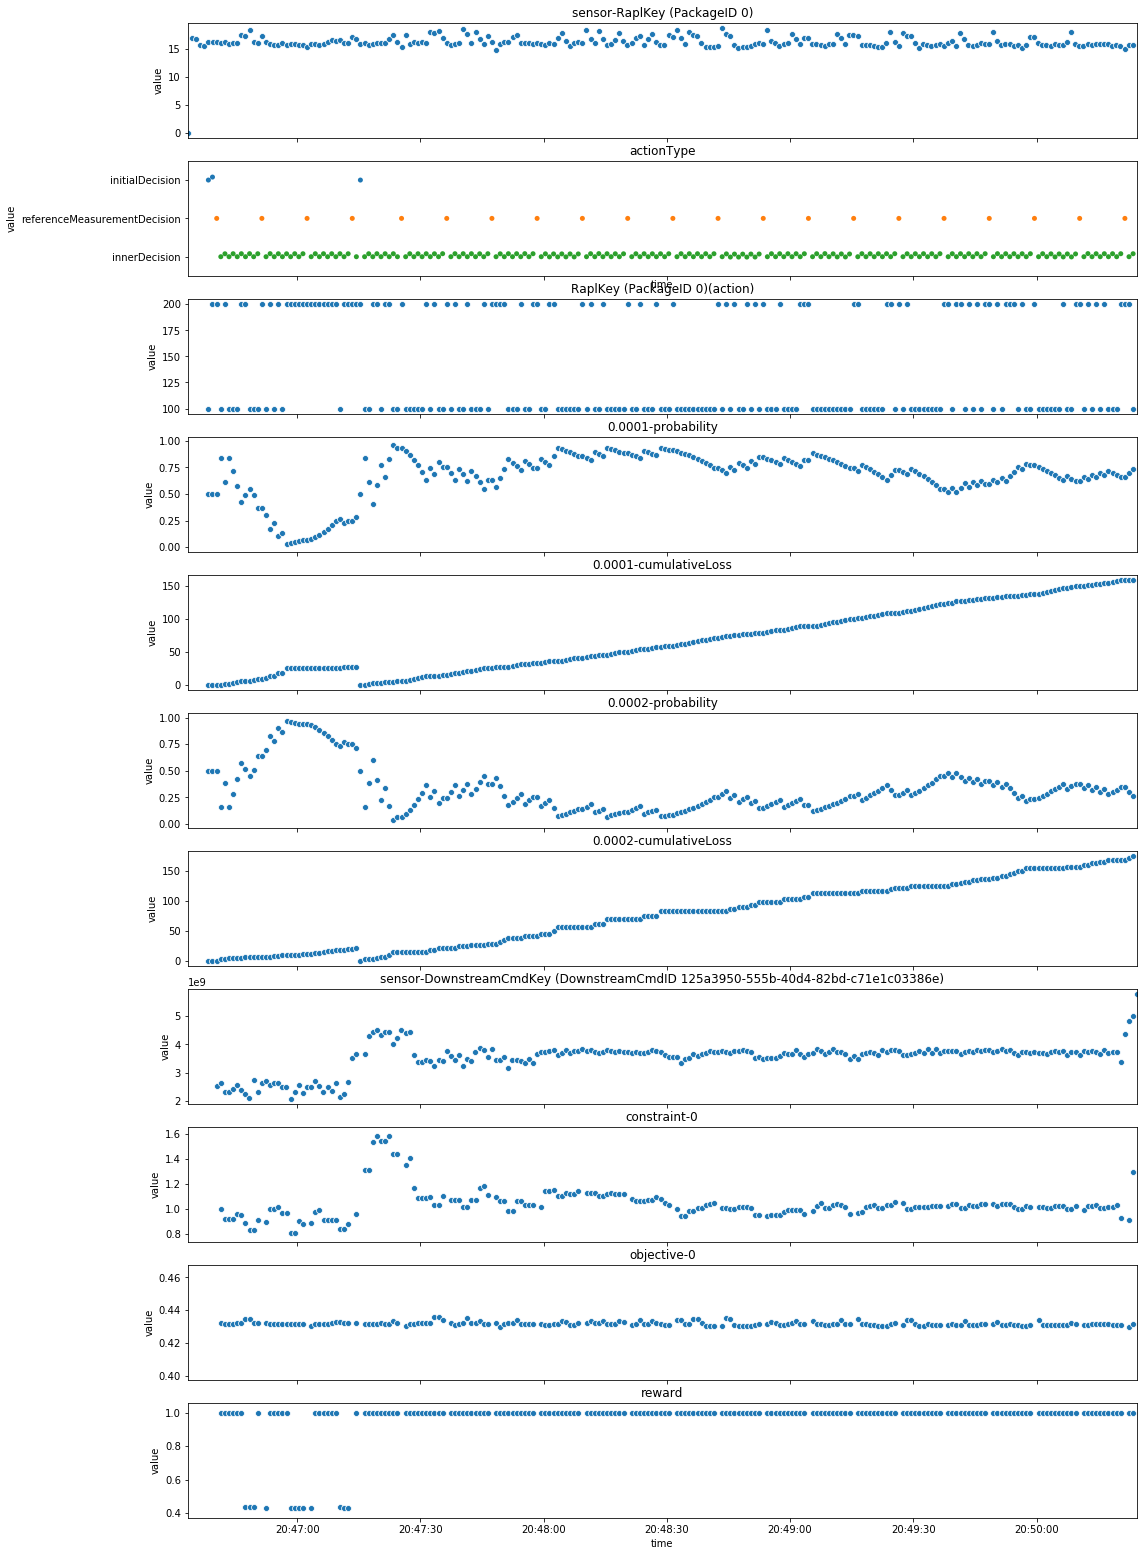

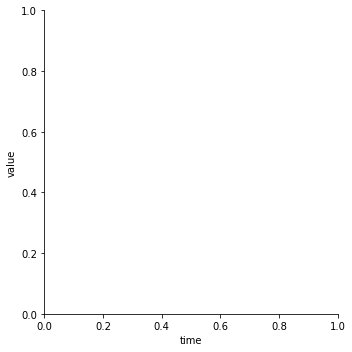

<IPython.core.display.Javascript object>

In [24]:
plot_history(history_controlOn, 11)

In [25]:
history_controlOn

defaultdict(list,
            {'sensor-RaplKey (PackageID 0)': [(1582058793415489.5, 0),
              (1582058794415182, 16.826420124194986),
              (1582058795415109.8, 16.76642737437758),
              (1582058796414947.8, 15.590437650916689),
              (1582058797414896.8, 15.398573327212622),
              (1582058798414135.5, 16.13950319680968),
              (1582058799414964.5, 16.09635612077676),
              (1582058800415225.8, 16.085599637097044),
              (1582058801414607.2, 15.917580023259623),
              (1582058802422748.2, 16.145980572169467),
              (1582058803415195.2, 15.755619191737116),
              (1582058804414435.8, 16.036857993662323),
              (1582058805415486, 15.948663915699127),
              (1582058806414521.8, 17.347981791461233),
              (1582058807423692, 17.2765229652668),
              (1582058808414174.2, 18.305466857197075),
              (1582058809415062.2, 16.161693416246532),
              (15820588104

<IPython.core.display.Javascript object>